# Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter

# Set Seeds for Reproducibility

In [2]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [3]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        # Handle tissue type label encoding
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [5]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True
    )
    
    # Get the fitted encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [6]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [7]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [8]:
# Analyze imaging type distribution across datasets and tissue types
print("=" * 60)
print("IMAGING TYPE ANALYSIS")
print("=" * 60)

for df_name, df in [("Train", train_df), ("Validation", valid_df), ("Test", test_df)]:
    print(f"\n{df_name} Set:")
    print(f"  Total samples: {len(df)}")
    print(f"\n  Imaging Type Distribution:")
    print(df['imaging type'].value_counts())
    print(f"\n  Imaging Type by Tissue Type:")
    print(df.groupby(['tissue type', 'imaging type']).size().unstack(fill_value=0))
    print("-" * 60)

IMAGING TYPE ANALYSIS

Train Set:
  Total samples: 1224

  Imaging Type Distribution:
imaging type
WLI    996
NBI    228
Name: count, dtype: int64

  Imaging Type by Tissue Type:
imaging type  NBI  WLI
tissue type           
HGC            45  264
LGC            97  385
NST            58  288
NTL            28   59
------------------------------------------------------------

Validation Set:
  Total samples: 304

  Imaging Type Distribution:
imaging type
WLI    250
NBI     54
Name: count, dtype: int64

  Imaging Type by Tissue Type:
imaging type  NBI  WLI
tissue type           
HGC             7   79
LGC            21   91
NST            17   67
NTL             9   13
------------------------------------------------------------

Test Set:
  Total samples: 189

  Imaging Type Distribution:
imaging type
WLI    150
NBI     39
Name: count, dtype: int64

  Imaging Type by Tissue Type:
imaging type  NBI  WLI
tissue type           
HGC            12   62
LGC            27   26
NST            

# Analyze Imaging Type Distribution

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Print encoding information
print(f"Tissue Types: {label_encoder.classes_}")

Tissue Types: ['HGC' 'LGC' 'NST' 'NTL']


# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [12]:
def create_regnet_y_400mf(num_classes=4, pretrained=True):
    """Create RegNet-Y-400MF model for bladder tissue classification"""
    model = models.regnet_y_400mf(weights='DEFAULT' if pretrained else None)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

def create_regnet_y_800mf(num_classes=4, pretrained=True):
    """Create RegNet-Y-800MF model for bladder tissue classification"""
    model = models.regnet_y_800mf(weights='DEFAULT' if pretrained else None)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

def create_regnet_y_1_6gf(num_classes=4, pretrained=True):
    """Create RegNet-Y-1.6GF model for bladder tissue classification"""
    model = models.regnet_y_1_6gf(weights='DEFAULT' if pretrained else None)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train RegNet-Y-400MF

Training RegNet-Y-400MF
Downloading: "https://download.pytorch.org/models/regnet_y_400mf-e6988f5f.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_400mf-e6988f5f.pth


100%|██████████| 16.8M/16.8M [00:00<00:00, 145MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.81it/s, Loss=0.4815, Acc=0.8421]


Train Loss: 0.4815 Acc: 0.8421 Macro-F1: 0.8023


Val : 100%|██████████| 10/10 [00:01<00:00,  7.01it/s, Loss=0.2449, Acc=0.9145]


Val Loss: 0.2449 Acc: 0.9145 Macro-F1: 0.9205
✓ New best model saved with validation macro-F1: 0.9205

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.09it/s, Loss=0.1017, Acc=0.9770]


Train Loss: 0.1017 Acc: 0.9770 Macro-F1: 0.9744


Val : 100%|██████████| 10/10 [00:01<00:00,  9.88it/s, Loss=0.0767, Acc=0.9803]


Val Loss: 0.0767 Acc: 0.9803 Macro-F1: 0.9751
✓ New best model saved with validation macro-F1: 0.9751

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.09it/s, Loss=0.0988, Acc=0.9720]


Train Loss: 0.0988 Acc: 0.9720 Macro-F1: 0.9578


Val : 100%|██████████| 10/10 [00:01<00:00,  9.76it/s, Loss=0.0651, Acc=0.9803]


Val Loss: 0.0651 Acc: 0.9803 Macro-F1: 0.9802
✓ New best model saved with validation macro-F1: 0.9802

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.06it/s, Loss=0.1062, Acc=0.9655]


Train Loss: 0.1062 Acc: 0.9655 Macro-F1: 0.9564


Val : 100%|██████████| 10/10 [00:01<00:00,  9.19it/s, Loss=0.0698, Acc=0.9770]


Val Loss: 0.0698 Acc: 0.9770 Macro-F1: 0.9819
✓ New best model saved with validation macro-F1: 0.9819

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.11it/s, Loss=0.0663, Acc=0.9737]


Train Loss: 0.0663 Acc: 0.9737 Macro-F1: 0.9679


Val : 100%|██████████| 10/10 [00:01<00:00,  9.65it/s, Loss=0.0427, Acc=0.9836]


Val Loss: 0.0427 Acc: 0.9836 Macro-F1: 0.9741

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.08it/s, Loss=0.0558, Acc=0.9827]


Train Loss: 0.0558 Acc: 0.9827 Macro-F1: 0.9820


Val : 100%|██████████| 10/10 [00:01<00:00,  9.70it/s, Loss=0.0528, Acc=0.9836]


Val Loss: 0.0528 Acc: 0.9836 Macro-F1: 0.9818

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.06it/s, Loss=0.0689, Acc=0.9770]


Train Loss: 0.0689 Acc: 0.9770 Macro-F1: 0.9668


Val : 100%|██████████| 10/10 [00:01<00:00,  9.11it/s, Loss=0.1120, Acc=0.9671]


Val Loss: 0.1120 Acc: 0.9671 Macro-F1: 0.9429

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.06it/s, Loss=0.0183, Acc=0.9926]


Train Loss: 0.0183 Acc: 0.9926 Macro-F1: 0.9880


Val : 100%|██████████| 10/10 [00:01<00:00,  9.77it/s, Loss=0.0042, Acc=1.0000]


Val Loss: 0.0042 Acc: 1.0000 Macro-F1: 1.0000
✓ New best model saved with validation macro-F1: 1.0000

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.02it/s, Loss=0.0074, Acc=0.9992]


Train Loss: 0.0074 Acc: 0.9992 Macro-F1: 0.9993


Val : 100%|██████████| 10/10 [00:01<00:00,  9.82it/s, Loss=0.0040, Acc=1.0000]


Val Loss: 0.0040 Acc: 1.0000 Macro-F1: 1.0000

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.18it/s, Loss=0.0103, Acc=0.9984]


Train Loss: 0.0103 Acc: 0.9984 Macro-F1: 0.9986


Val : 100%|██████████| 10/10 [00:01<00:00,  9.93it/s, Loss=0.0027, Acc=1.0000]


Val Loss: 0.0027 Acc: 1.0000 Macro-F1: 1.0000

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.08it/s, Loss=0.0044, Acc=0.9992]


Train Loss: 0.0044 Acc: 0.9992 Macro-F1: 0.9992


Val : 100%|██████████| 10/10 [00:01<00:00,  9.53it/s, Loss=0.0021, Acc=1.0000]


Val Loss: 0.0021 Acc: 1.0000 Macro-F1: 1.0000

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.13it/s, Loss=0.0045, Acc=0.9992]


Train Loss: 0.0045 Acc: 0.9992 Macro-F1: 0.9982


Val : 100%|██████████| 10/10 [00:01<00:00,  9.93it/s, Loss=0.0017, Acc=1.0000]


Val Loss: 0.0017 Acc: 1.0000 Macro-F1: 1.0000

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.15it/s, Loss=0.0036, Acc=1.0000]


Train Loss: 0.0036 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  9.65it/s, Loss=0.0017, Acc=1.0000]


Val Loss: 0.0017 Acc: 1.0000 Macro-F1: 1.0000
Early stopping triggered after 13 epochs
Training complete in 1m 25s
Best validation macro-F1: 1.0000


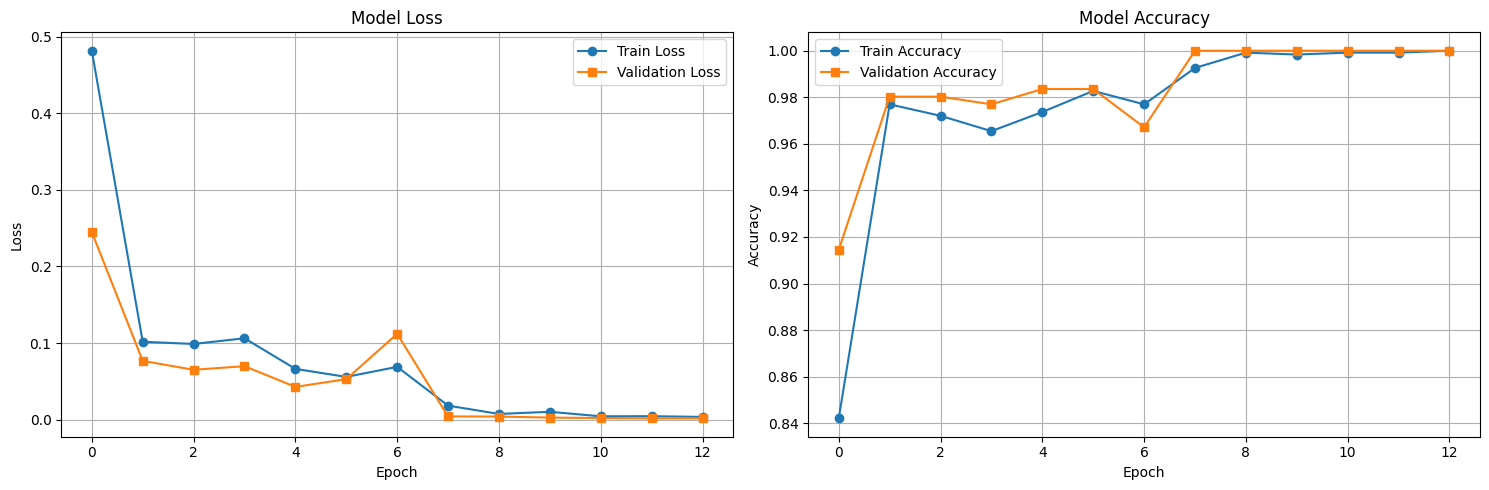

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  5.70it/s]


Test Accuracy: 47.09%
Test Loss: 2.4249

Classification Report:
              precision    recall  f1-score   support

         HGC       0.60      0.47      0.53        74
         LGC       0.12      0.06      0.08        53
         NST       0.68      0.86      0.76        37
         NTL       0.32      0.76      0.45        25

    accuracy                           0.47       189
   macro avg       0.43      0.54      0.45       189
weighted avg       0.45      0.47      0.44       189


Confusion Matrix:
[[35 21  9  9]
 [23  3  0 27]
 [ 0  0 32  5]
 [ 0  0  6 19]]

ROC-AUC Scores:
Macro-average AUC: 0.7212
Micro-average AUC: 0.6894
HGC AUC: 0.7501
LGC AUC: 0.3897
NST AUC: 0.9262
NTL AUC: 0.8188


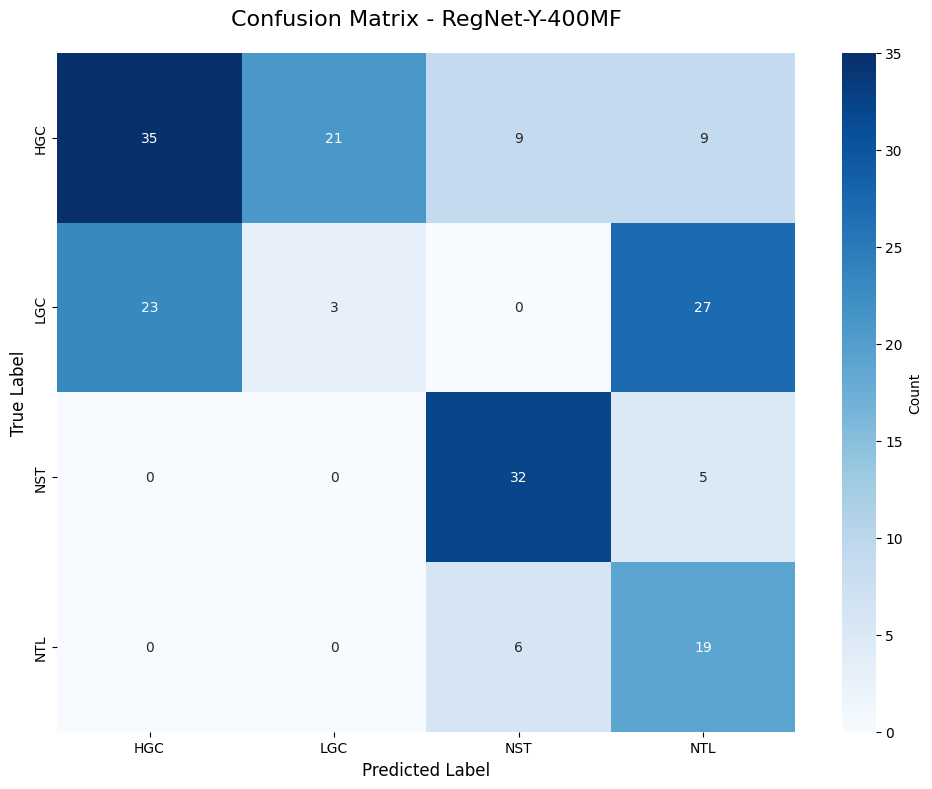

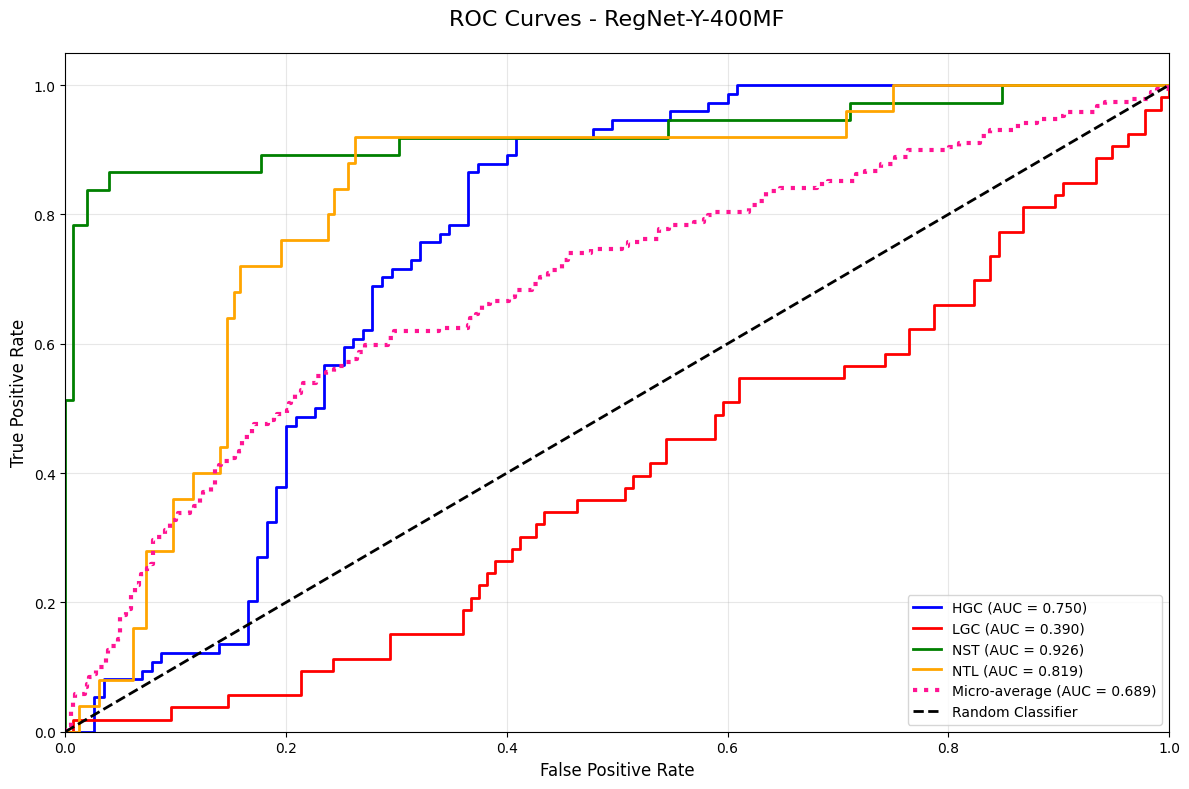


RegNet-Y-400MF training and evaluation complete!


In [16]:
print("=" * 80)
print("Training RegNet-Y-400MF")
print("=" * 80)

# Create RegNet-Y-400MF model
regnet_400mf = create_regnet_y_400mf(
    num_classes=4, 
    pretrained=True
)

# Create trainer
trainer_400mf = ModelTrainer(regnet_400mf, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_400mf = trainer_400mf.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="RegNet-Y-400MF")

# Plot training history
trainer_400mf.plot_training_history(save_path='regnet_y_400mf_training_history.png')

# Evaluate model
results_400mf = trainer_400mf.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_400mf['confusion_matrix'], class_names, 'RegNet-Y-400MF',
                      save_path='regnet_y_400mf_confusion_matrix.png')
# Plot ROC curves
roc_auc_400mf = plot_roc_curves(results_400mf['labels'], results_400mf['probabilities'], class_names, 'RegNet-Y-400MF',
                              save_path='regnet_y_400mf_roc_curves.png')
# Store results
results_400mf['model_name'] = 'RegNet-Y-400MF'
results_400mf['roc_auc'] = roc_auc_400mf
all_results.append(results_400mf)

print("\nRegNet-Y-400MF training and evaluation complete!")

## Train RegNet-Y-800MF

Training RegNet-Y-800MF
Downloading: "https://download.pytorch.org/models/regnet_y_800mf-58fc7688.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_800mf-58fc7688.pth


100%|██████████| 24.8M/24.8M [00:00<00:00, 84.6MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.17it/s, Loss=0.3881, Acc=0.8791]


Train Loss: 0.3881 Acc: 0.8791 Macro-F1: 0.8404


Val : 100%|██████████| 10/10 [00:01<00:00,  9.82it/s, Loss=0.2677, Acc=0.9342]


Val Loss: 0.2677 Acc: 0.9342 Macro-F1: 0.9270
✓ New best model saved with validation macro-F1: 0.9270

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.24it/s, Loss=0.1950, Acc=0.9465]


Train Loss: 0.1950 Acc: 0.9465 Macro-F1: 0.9292


Val : 100%|██████████| 10/10 [00:01<00:00, 10.00it/s, Loss=0.0534, Acc=0.9836]


Val Loss: 0.0534 Acc: 0.9836 Macro-F1: 0.9778
✓ New best model saved with validation macro-F1: 0.9778

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.20it/s, Loss=0.1282, Acc=0.9507]


Train Loss: 0.1282 Acc: 0.9507 Macro-F1: 0.9336


Val : 100%|██████████| 10/10 [00:00<00:00, 10.03it/s, Loss=0.9739, Acc=0.7993]


Val Loss: 0.9739 Acc: 0.7993 Macro-F1: 0.7382

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.23it/s, Loss=0.0969, Acc=0.9720]


Train Loss: 0.0969 Acc: 0.9720 Macro-F1: 0.9644


Val : 100%|██████████| 10/10 [00:01<00:00,  9.88it/s, Loss=0.0327, Acc=0.9967]


Val Loss: 0.0327 Acc: 0.9967 Macro-F1: 0.9927
✓ New best model saved with validation macro-F1: 0.9927

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.18it/s, Loss=0.1600, Acc=0.9622]


Train Loss: 0.1600 Acc: 0.9622 Macro-F1: 0.9423


Val : 100%|██████████| 10/10 [00:01<00:00,  9.86it/s, Loss=0.1142, Acc=0.9605]


Val Loss: 0.1142 Acc: 0.9605 Macro-F1: 0.9566

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.24it/s, Loss=0.0832, Acc=0.9770]


Train Loss: 0.0832 Acc: 0.9770 Macro-F1: 0.9755


Val : 100%|██████████| 10/10 [00:01<00:00,  9.46it/s, Loss=0.2764, Acc=0.9408]


Val Loss: 0.2764 Acc: 0.9408 Macro-F1: 0.9388

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.22it/s, Loss=0.0781, Acc=0.9770]


Train Loss: 0.0781 Acc: 0.9770 Macro-F1: 0.9651


Val : 100%|██████████| 10/10 [00:01<00:00,  9.16it/s, Loss=0.1706, Acc=0.9507]


Val Loss: 0.1706 Acc: 0.9507 Macro-F1: 0.9423

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.20it/s, Loss=0.0446, Acc=0.9893]


Train Loss: 0.0446 Acc: 0.9893 Macro-F1: 0.9842


Val : 100%|██████████| 10/10 [00:01<00:00,  9.76it/s, Loss=0.0218, Acc=0.9868]


Val Loss: 0.0218 Acc: 0.9868 Macro-F1: 0.9813

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:05<00:00,  7.23it/s, Loss=0.0083, Acc=0.9984]


Train Loss: 0.0083 Acc: 0.9984 Macro-F1: 0.9986


Val : 100%|██████████| 10/10 [00:01<00:00,  9.32it/s, Loss=0.0173, Acc=0.9901]


Val Loss: 0.0173 Acc: 0.9901 Macro-F1: 0.9839
Early stopping triggered after 9 epochs
Training complete in 0m 57s
Best validation macro-F1: 0.9927


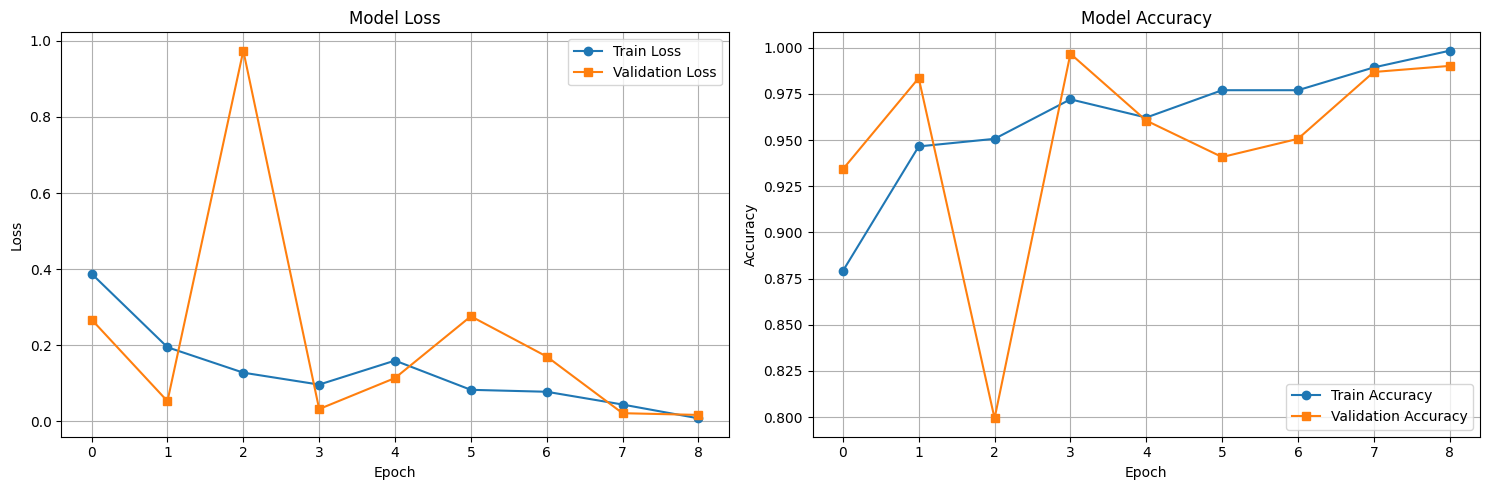

Evaluating on test set...


100%|██████████| 6/6 [00:00<00:00,  7.87it/s]


Test Accuracy: 39.15%
Test Loss: 2.9554

Classification Report:
              precision    recall  f1-score   support

         HGC       0.46      0.36      0.41        74
         LGC       0.08      0.08      0.08        53
         NST       0.69      0.84      0.76        37
         NTL       0.36      0.48      0.41        25

    accuracy                           0.39       189
   macro avg       0.40      0.44      0.41       189
weighted avg       0.38      0.39      0.38       189


Confusion Matrix:
[[27 46  1  0]
 [27  4  5 17]
 [ 2  0 31  4]
 [ 3  2  8 12]]

ROC-AUC Scores:
Macro-average AUC: 0.6646
Micro-average AUC: 0.6519
HGC AUC: 0.5917
LGC AUC: 0.4172
NST AUC: 0.9388
NTL AUC: 0.7107


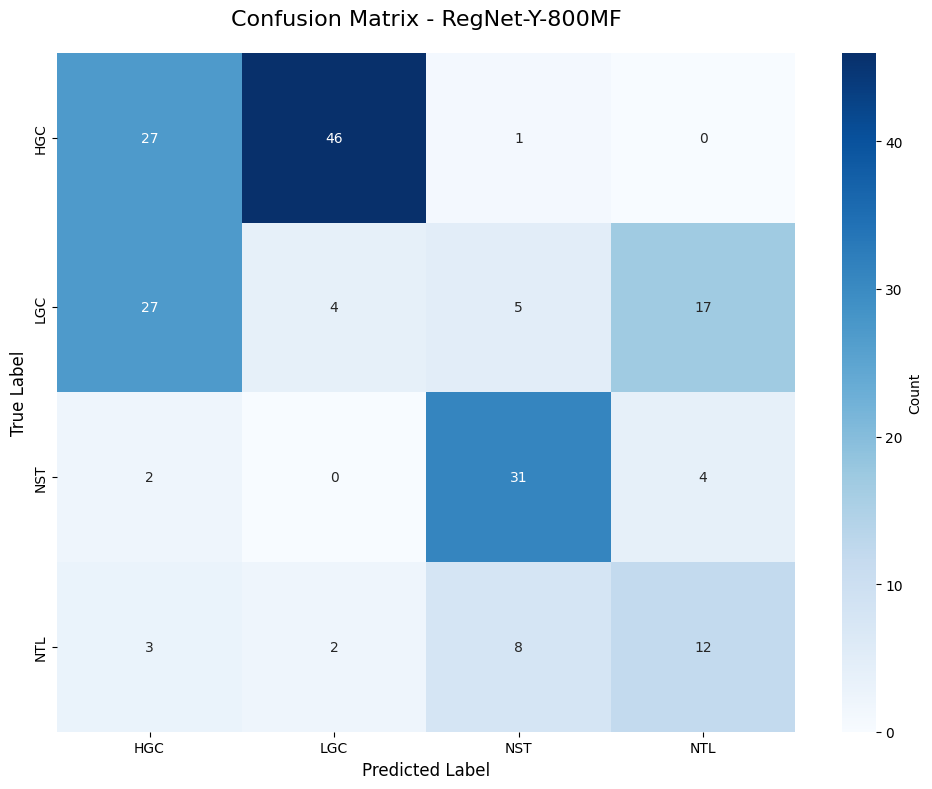

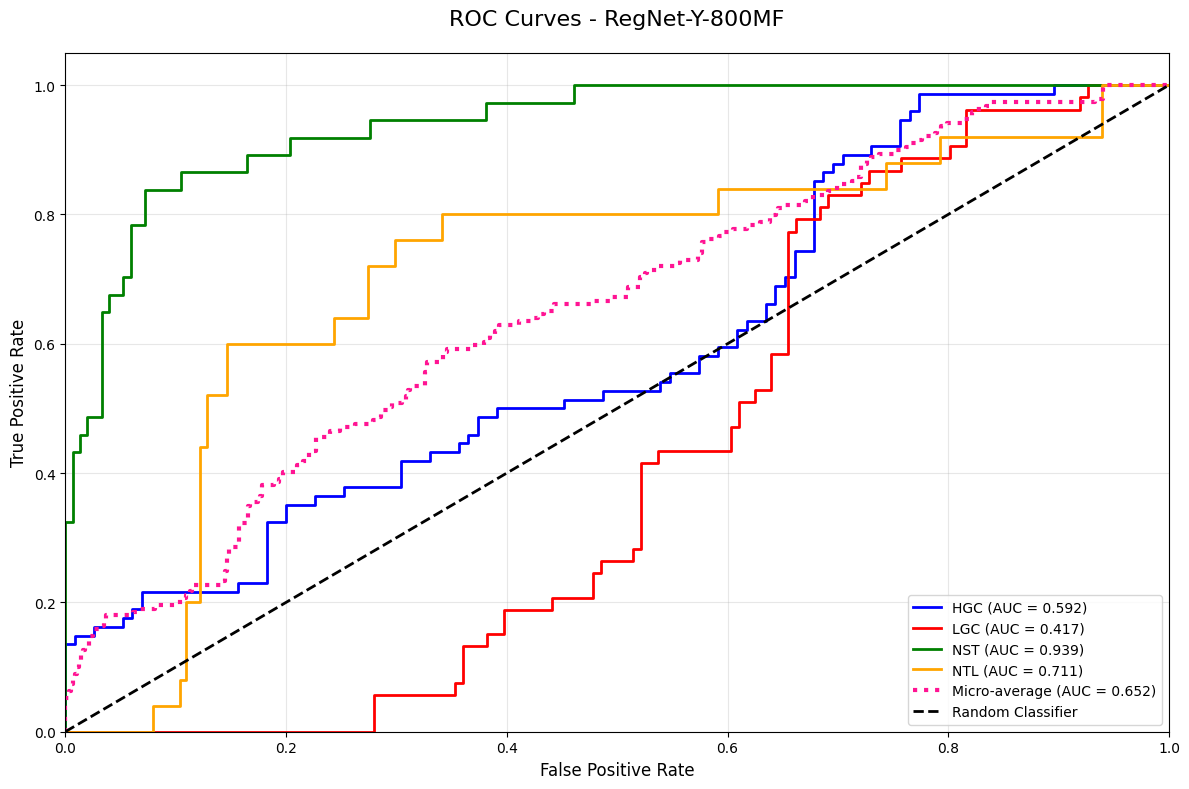


RegNet-Y-800MF training and evaluation complete!


In [17]:
print("=" * 80)
print("Training RegNet-Y-800MF")
print("=" * 80)

# Create RegNet-Y-800MF model
regnet_800mf = create_regnet_y_800mf(
    num_classes=4, 
    pretrained=True
)

# Create trainer
trainer_800mf = ModelTrainer(regnet_800mf, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_800mf = trainer_800mf.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="RegNet-Y-800MF")

# Plot training history
trainer_800mf.plot_training_history(save_path='regnet_y_800mf_training_history.png')

# Evaluate model
results_800mf = trainer_800mf.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_800mf['confusion_matrix'], class_names, 'RegNet-Y-800MF',
                      save_path='regnet_y_800mf_confusion_matrix.png')
# Plot ROC curves
roc_auc_800mf = plot_roc_curves(results_800mf['labels'], results_800mf['probabilities'], class_names, 'RegNet-Y-800MF',
                              save_path='regnet_y_800mf_roc_curves.png')
# Store results
results_800mf['model_name'] = 'RegNet-Y-800MF'
results_800mf['roc_auc'] = roc_auc_800mf
all_results.append(results_800mf)

print("\nRegNet-Y-800MF training and evaluation complete!")

## Train RegNet-Y-1.6GF

Training RegNet-Y-1.6GF
Downloading: "https://download.pytorch.org/models/regnet_y_1_6gf-0d7bc02a.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_1_6gf-0d7bc02a.pth


100%|██████████| 43.2M/43.2M [00:01<00:00, 28.6MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.75it/s, Loss=0.4727, Acc=0.8470]


Train Loss: 0.4727 Acc: 0.8470 Macro-F1: 0.8052


Val : 100%|██████████| 10/10 [00:01<00:00,  8.94it/s, Loss=1.4658, Acc=0.7072]


Val Loss: 1.4658 Acc: 0.7072 Macro-F1: 0.6554
✓ New best model saved with validation macro-F1: 0.6554

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.81it/s, Loss=0.1750, Acc=0.9433]


Train Loss: 0.1750 Acc: 0.9433 Macro-F1: 0.9214


Val : 100%|██████████| 10/10 [00:01<00:00,  8.45it/s, Loss=0.1728, Acc=0.9441]


Val Loss: 0.1728 Acc: 0.9441 Macro-F1: 0.9258
✓ New best model saved with validation macro-F1: 0.9258

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.81it/s, Loss=0.0872, Acc=0.9704]


Train Loss: 0.0872 Acc: 0.9704 Macro-F1: 0.9638


Val : 100%|██████████| 10/10 [00:01<00:00,  9.35it/s, Loss=0.0690, Acc=0.9770]


Val Loss: 0.0690 Acc: 0.9770 Macro-F1: 0.9692
✓ New best model saved with validation macro-F1: 0.9692

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.78it/s, Loss=0.0622, Acc=0.9794]


Train Loss: 0.0622 Acc: 0.9794 Macro-F1: 0.9786


Val : 100%|██████████| 10/10 [00:01<00:00,  8.55it/s, Loss=0.0236, Acc=0.9934]


Val Loss: 0.0236 Acc: 0.9934 Macro-F1: 0.9948
✓ New best model saved with validation macro-F1: 0.9948

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.78it/s, Loss=0.0188, Acc=0.9926]


Train Loss: 0.0188 Acc: 0.9926 Macro-F1: 0.9930


Val : 100%|██████████| 10/10 [00:01<00:00,  9.05it/s, Loss=0.0226, Acc=0.9934]


Val Loss: 0.0226 Acc: 0.9934 Macro-F1: 0.9904

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.80it/s, Loss=0.0318, Acc=0.9901]


Train Loss: 0.0318 Acc: 0.9901 Macro-F1: 0.9888


Val : 100%|██████████| 10/10 [00:01<00:00,  9.15it/s, Loss=0.0467, Acc=0.9803]


Val Loss: 0.0467 Acc: 0.9803 Macro-F1: 0.9803

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.81it/s, Loss=0.1516, Acc=0.9465]


Train Loss: 0.1516 Acc: 0.9465 Macro-F1: 0.9368


Val : 100%|██████████| 10/10 [00:01<00:00,  8.65it/s, Loss=0.4391, Acc=0.8651]


Val Loss: 0.4391 Acc: 0.8651 Macro-F1: 0.8165

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.80it/s, Loss=0.0721, Acc=0.9762]


Train Loss: 0.0721 Acc: 0.9762 Macro-F1: 0.9672


Val : 100%|██████████| 10/10 [00:01<00:00,  9.49it/s, Loss=0.0299, Acc=0.9868]


Val Loss: 0.0299 Acc: 0.9868 Macro-F1: 0.9852

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.81it/s, Loss=0.0182, Acc=0.9975]


Train Loss: 0.0182 Acc: 0.9975 Macro-F1: 0.9980


Val : 100%|██████████| 10/10 [00:01<00:00,  9.34it/s, Loss=0.0221, Acc=0.9901]


Val Loss: 0.0221 Acc: 0.9901 Macro-F1: 0.9878
Early stopping triggered after 9 epochs
Training complete in 1m 22s
Best validation macro-F1: 0.9948


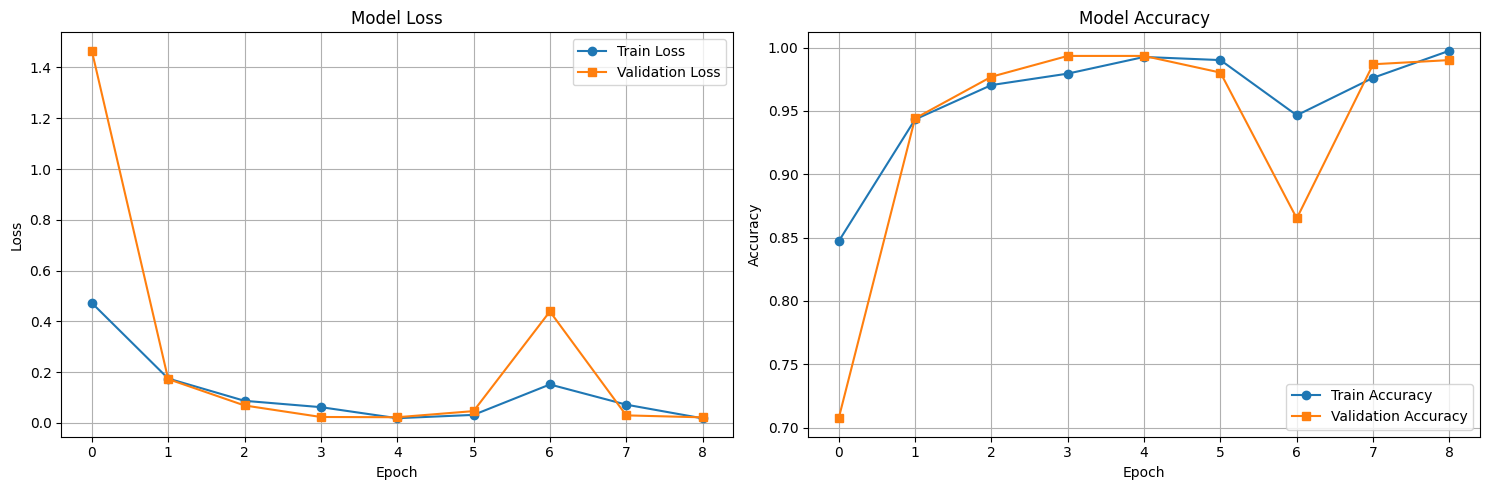

Evaluating on test set...


100%|██████████| 6/6 [00:00<00:00,  7.50it/s]


Test Accuracy: 31.75%
Test Loss: 2.8109

Classification Report:
              precision    recall  f1-score   support

         HGC       0.67      0.19      0.29        74
         LGC       0.09      0.08      0.08        53
         NST       0.58      0.89      0.70        37
         NTL       0.13      0.36      0.19        25

    accuracy                           0.32       189
   macro avg       0.37      0.38      0.32       189
weighted avg       0.42      0.32      0.30       189


Confusion Matrix:
[[14 39  2 19]
 [ 7  4  6 36]
 [ 0  0 33  4]
 [ 0  0 16  9]]

ROC-AUC Scores:
Macro-average AUC: 0.6311
Micro-average AUC: 0.5935
HGC AUC: 0.5729
LGC AUC: 0.4946
NST AUC: 0.9456
NTL AUC: 0.5112


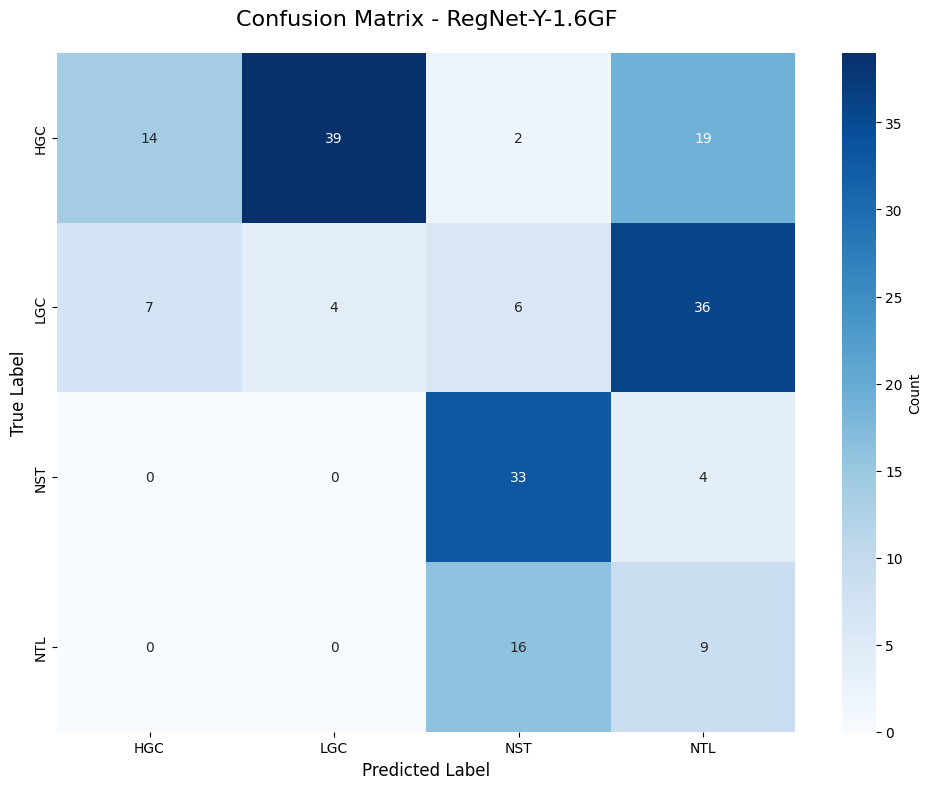

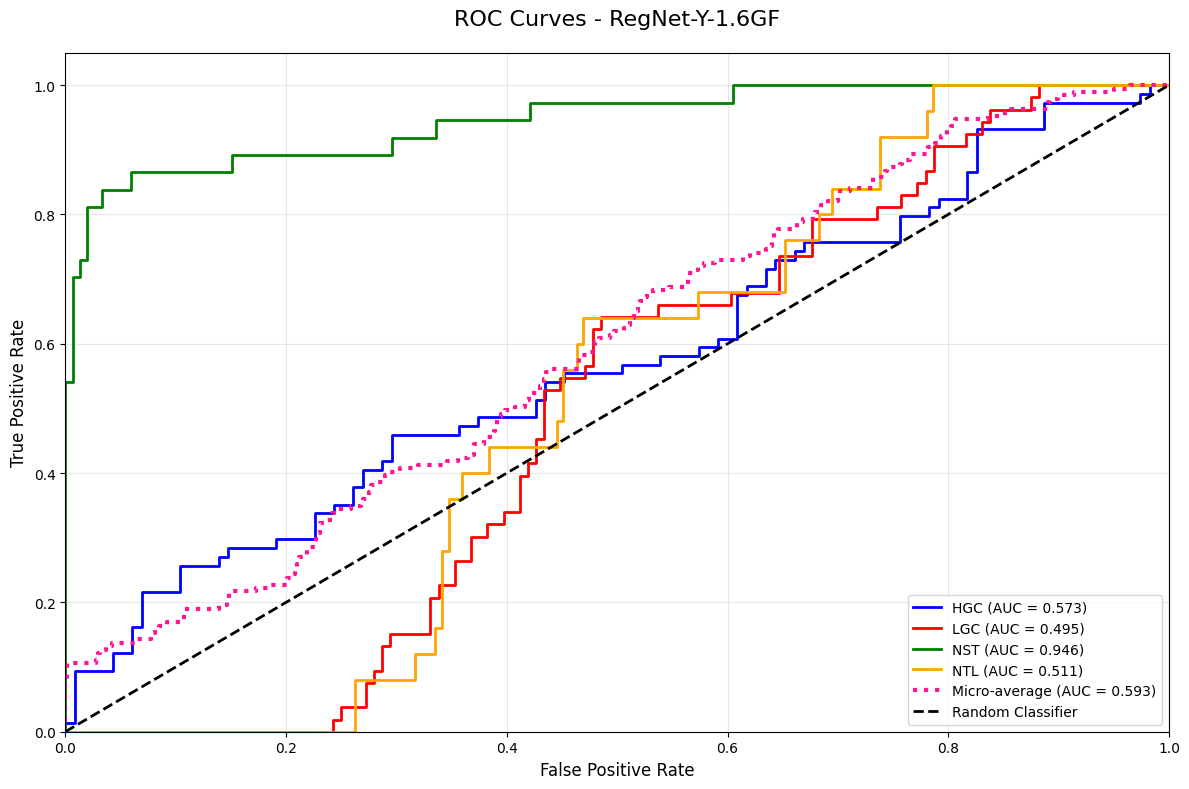


RegNet-Y-1.6GF training and evaluation complete!


In [18]:
print("=" * 80)
print("Training RegNet-Y-1.6GF")
print("=" * 80)

# Create RegNet-Y-1.6GF model
regnet_1_6gf = create_regnet_y_1_6gf(
    num_classes=4, 
    pretrained=True
)

# Create trainer
trainer_1_6gf = ModelTrainer(regnet_1_6gf, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_1_6gf = trainer_1_6gf.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="RegNet-Y-1.6GF")

# Plot training history
trainer_1_6gf.plot_training_history(save_path='regnet_y_1_6gf_training_history.png')

# Evaluate model
results_1_6gf = trainer_1_6gf.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_1_6gf['confusion_matrix'], class_names, 'RegNet-Y-1.6GF',
                      save_path='regnet_y_1_6gf_confusion_matrix.png')
# Plot ROC curves
roc_auc_1_6gf = plot_roc_curves(results_1_6gf['labels'], results_1_6gf['probabilities'], class_names, 'RegNet-Y-1.6GF',
                              save_path='regnet_y_1_6gf_roc_curves.png')
# Store results
results_1_6gf['model_name'] = 'RegNet-Y-1.6GF'
results_1_6gf['roc_auc'] = roc_auc_1_6gf
all_results.append(results_1_6gf)

print("\nRegNet-Y-1.6GF training and evaluation complete!")

# Save All Metrics to CSV

In [19]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'RegNet_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())



Metrics saved to: RegNet_metrics.csv

Metrics Summary:
            Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  RegNet-Y-400MF         47.089947      2.424877             0.431492          0.538610      0.454297                0.446499             0.470899         0.437774       0.603448    0.472973  0.530303         74.0       0.125000    0.056604  0.077922         53.0       0.680851    0.864865  0.761905         37.0       0.316667        0.76  0.447059         25.0   0.721189   0.689408  0.750059  0.389706  0.926209  0.818780      0.750059 